# Telecom Churn Case Study

## Problem Statement

### Business problem overview
The telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.
In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### High-value churn
In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.
In this project, we will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

### Understanding the business objective and the data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.
The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the action phase, while the fourth month is the churn phase.

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the required libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

In [3]:
# Reading the csv file 
telecom = pd.read_csv("telecom_churn_data.csv")

In [4]:
# Checking the dimensions of the dataset
telecom.shape

(99999, 226)

### Filtering High Value Customers

High value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of 
the average recharge amount in the first two months (the good phase)


1. Deriving the features to extract high value customers
2. Finding out the total amount spent by customers on data recharge.
   We have two columns available to find this out 
    - first column is av_rech_amt_data_x (x represents month here, which would be either 6 or 7 or 8)
    - second column is total_rech_data_x (x represents month here, which would be either 6 or 7 or 8)
3. Introducing a new column total_rech_data_amt_x which can be calculated as av_rech_amt_data_x * total_rech_data_x

In [5]:
telecom['total_rech_data_amt_6'] = telecom['av_rech_amt_data_6'] * telecom['total_rech_data_6']
telecom['total_rech_data_amt_7'] = telecom['av_rech_amt_data_7'] * telecom['total_rech_data_7']
telecom['total_rech_data_amt_8'] = telecom['av_rech_amt_data_8'] * telecom['total_rech_data_8']
telecom['total_rech_data_amt_9'] = telecom['av_rech_amt_data_9'] * telecom['total_rech_data_9']

In [6]:
# Since we dont need columns av_rech_amt_data_x,total_rech_data_x (x = 6/7/8) ,lets drop them
telecom.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis = 1,inplace = True)

Next, we have to find the average recharge done in the first two months (June & July) 6,7 - the good phase
which is the sum of total data recharge done and total call or sms recharge done divided by 2 

In [7]:
telecom_av_rech_6n7 = (telecom['total_rech_amt_6'].fillna(0) + telecom['total_rech_amt_7'].fillna(0) 
+ telecom['total_rech_data_amt_6'].fillna(0) + telecom['total_rech_data_amt_7'].fillna(0))/2

In [8]:
# taking 70 percentile of the calculated average amount
percentile_70_6n7 = np.percentile(telecom_av_rech_6n7, 70.0)
print("70 percentile is : ", percentile_70_6n7)

70 percentile is :  478.0


In [9]:
# filtering the given data set based on 70th percentile
telecom_hv_cust = telecom[telecom_av_rech_6n7 >= percentile_70_6n7]

print("Dimensions of the filtered dataset:",telecom_hv_cust.shape)

Dimensions of the filtered dataset: (30001, 222)


1. Next, Let's introduce a new column "churn", with values either 1 (churn) or 0 (non-churn). 
2. Tagging of churn/non-churn will be based on the 4th month (9)  as follows: 
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:
- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

In [10]:
telecom_hv_cust['churn'] = np.where(telecom_hv_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)
telecom_hv_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_rech_data_amt_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0,0


In [11]:
# lets find out churn/non churn percentage
telecom_hv_cust['churn'].value_counts()/len(telecom_hv_cust)*100

0    91.863605
1     8.136395
Name: churn, dtype: float64

As you can see, 91% of the customers do not churn and only 8% churn.This might be a case of class imbalance, we will treat it later

In [12]:
# lets check the columns with no variance in their values and drop such columns
for i in telecom_hv_cust.columns:
    if telecom_hv_cust[i].nunique() == 1:
        print("\nColumn",i,"has no variance and contains only", telecom_hv_cust[i].nunique(),"unique value")
        print("Dropping the column",i)
        telecom_hv_cust.drop(i,axis=1,inplace = True)

print("\nDimension of the updated dataset:",telecom_hv_cust.shape)


Column circle_id has no variance and contains only 1 unique value
Dropping the column circle_id

Column loc_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_og_t2o_mou

Column std_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column std_og_t2o_mou

Column loc_ic_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_ic_t2o_mou

Column last_date_of_month_6 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_6

Column last_date_of_month_7 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_7

Column last_date_of_month_8 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_8

Column last_date_of_month_9 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_9

Column std_og_t2c_mou_6 has no variance and contains only 1 unique value
Dropping the column std_og_t2c_m

In [13]:
# lets check the null values present in the dataset
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

arpu_3g_9                   49.268358
fb_user_9                   49.268358
date_of_last_rech_data_9    49.268358
max_rech_data_9             49.268358
count_rech_2g_9             49.268358
                              ...    
max_rech_amt_8               0.000000
max_rech_amt_7               0.000000
max_rech_amt_6               0.000000
total_rech_amt_9             0.000000
churn                        0.000000
Length: 207, dtype: float64

In [14]:
# Dropping columns with > 30% of missing values except 9th month's columns
cols = telecom_hv_cust.columns
telecom_null_perc = telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)
telecom_null_df = pd.DataFrame({'col_name': cols,
                                 'perc_null': telecom_null_perc})

drop_cols = telecom_null_df.loc[(telecom_null_df["col_name"].str.contains('_9')==False) & (telecom_null_df["perc_null"] > 30.0)]["col_name"]
print("list of columns to be dropped:",drop_cols)

list of columns to be dropped: date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_

In [15]:
# lets drop these columns
telecom_hv_cust.drop(drop_cols, axis=1,inplace = True)
telecom_hv_cust.shape

(30001, 180)

In [16]:
# checking for columns that need to be changed to integer, float or date data types
object_col_data = telecom_hv_cust.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


All the columns above can be converted to date data type

In [17]:
# converting the above columns to datetime
for col in object_col_data.columns:
    telecom_hv_cust[col] = pd.to_datetime(telecom_hv_cust[col])


In [18]:
#checking if it changed 
object_col_data = telecom_hv_cust.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

Series([], Name: 0, dtype: float64)


In [19]:
# checking for correlation between the features
cor = telecom_hv_cust.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

monthly_3g_6      vol_3g_mb_6         0.601308
total_ic_mou_7    loc_ic_t2t_mou_7    0.601684
arpu_2g_9         count_rech_3g_9     0.602386
total_og_mou_8    onnet_mou_9         0.603450
total_rech_amt_8  arpu_6              0.603673
                                        ...   
isd_og_mou_8      isd_og_mou_7        0.949809
                  isd_og_mou_6        0.950194
total_rech_amt_9  arpu_9              0.950539
total_rech_amt_8  arpu_8              0.955351
sachet_2g_9       count_rech_2g_9     0.980131
Length: 337, dtype: float64

In [20]:
# dropping the columns with high correlation (+/- 60%)
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
                 
telecom_hv_cust.drop(drop_col_list, axis=1, inplace=True)
telecom_hv_cust.shape

(30001, 125)

In [21]:
# Creating a list of the 9th month columns
cols_to_drop = [col for col in telecom_hv_cust.columns if '_9' in col]
print(cols_to_drop)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'total_rech_data_amt_9']


In [22]:
# Dropping the 9th month columns 
telecom_hv_cust.drop(cols_to_drop, axis=1, inplace=True)
telecom_hv_cust.shape

(30001, 88)

In [23]:
# Checking the dataset for null values
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

loc_og_t2c_mou_8      3.913203
roam_ic_mou_8         3.913203
spl_og_mou_8          3.913203
isd_og_mou_8          3.913203
std_og_mou_8          3.913203
                        ...   
last_day_rch_amt_7    0.000000
last_day_rch_amt_8    0.000000
vol_2g_mb_6           0.000000
vol_2g_mb_7           0.000000
churn                 0.000000
Length: 88, dtype: float64

We are left with few columns with null values less than 4% 

In [24]:
# dropping the rows with null values in each column 
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_8'])]

In [25]:
# Checking the dataset for null values again
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

mobile_number         0.0
arpu_6                0.0
last_day_rch_amt_6    0.0
max_rech_amt_8        0.0
max_rech_amt_7        0.0
                     ... 
std_og_mou_8          0.0
std_og_mou_7          0.0
std_og_mou_6          0.0
std_og_t2f_mou_8      0.0
churn                 0.0
Length: 88, dtype: float64

In [26]:
# lets write a function to plot historgram for some sample columns
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [27]:
# function to plot correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "Telecom Churn"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [28]:
# function to plot scatter plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

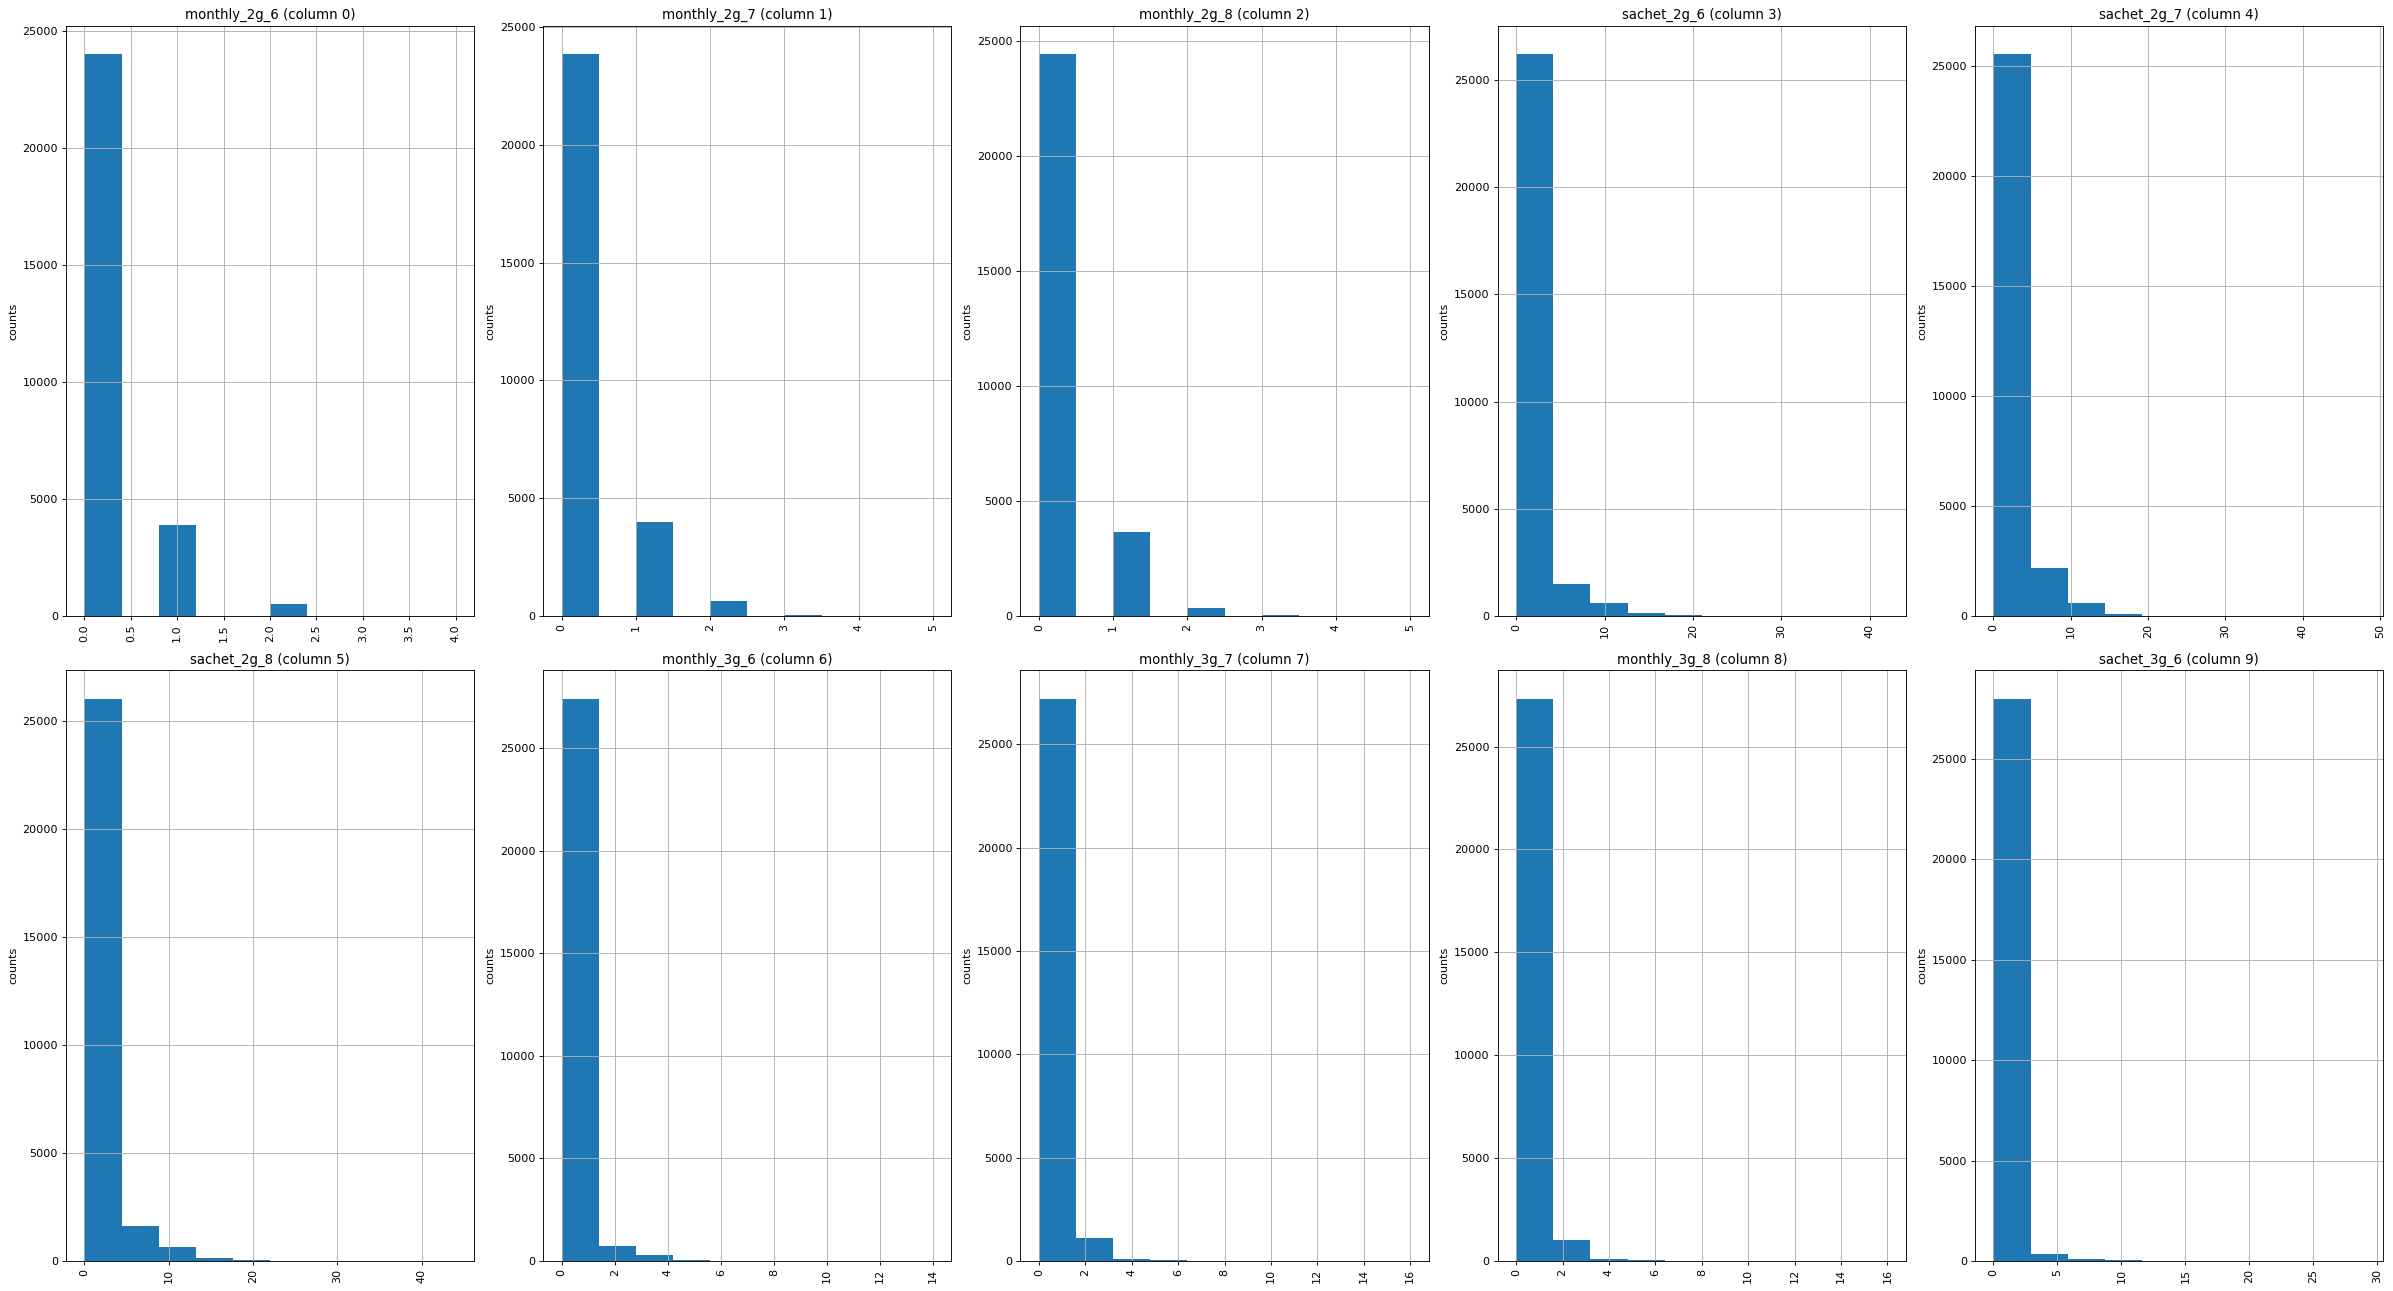

In [29]:
# calling the function to plot the graphs
plotPerColumnDistribution(telecom_hv_cust, 10, 5)

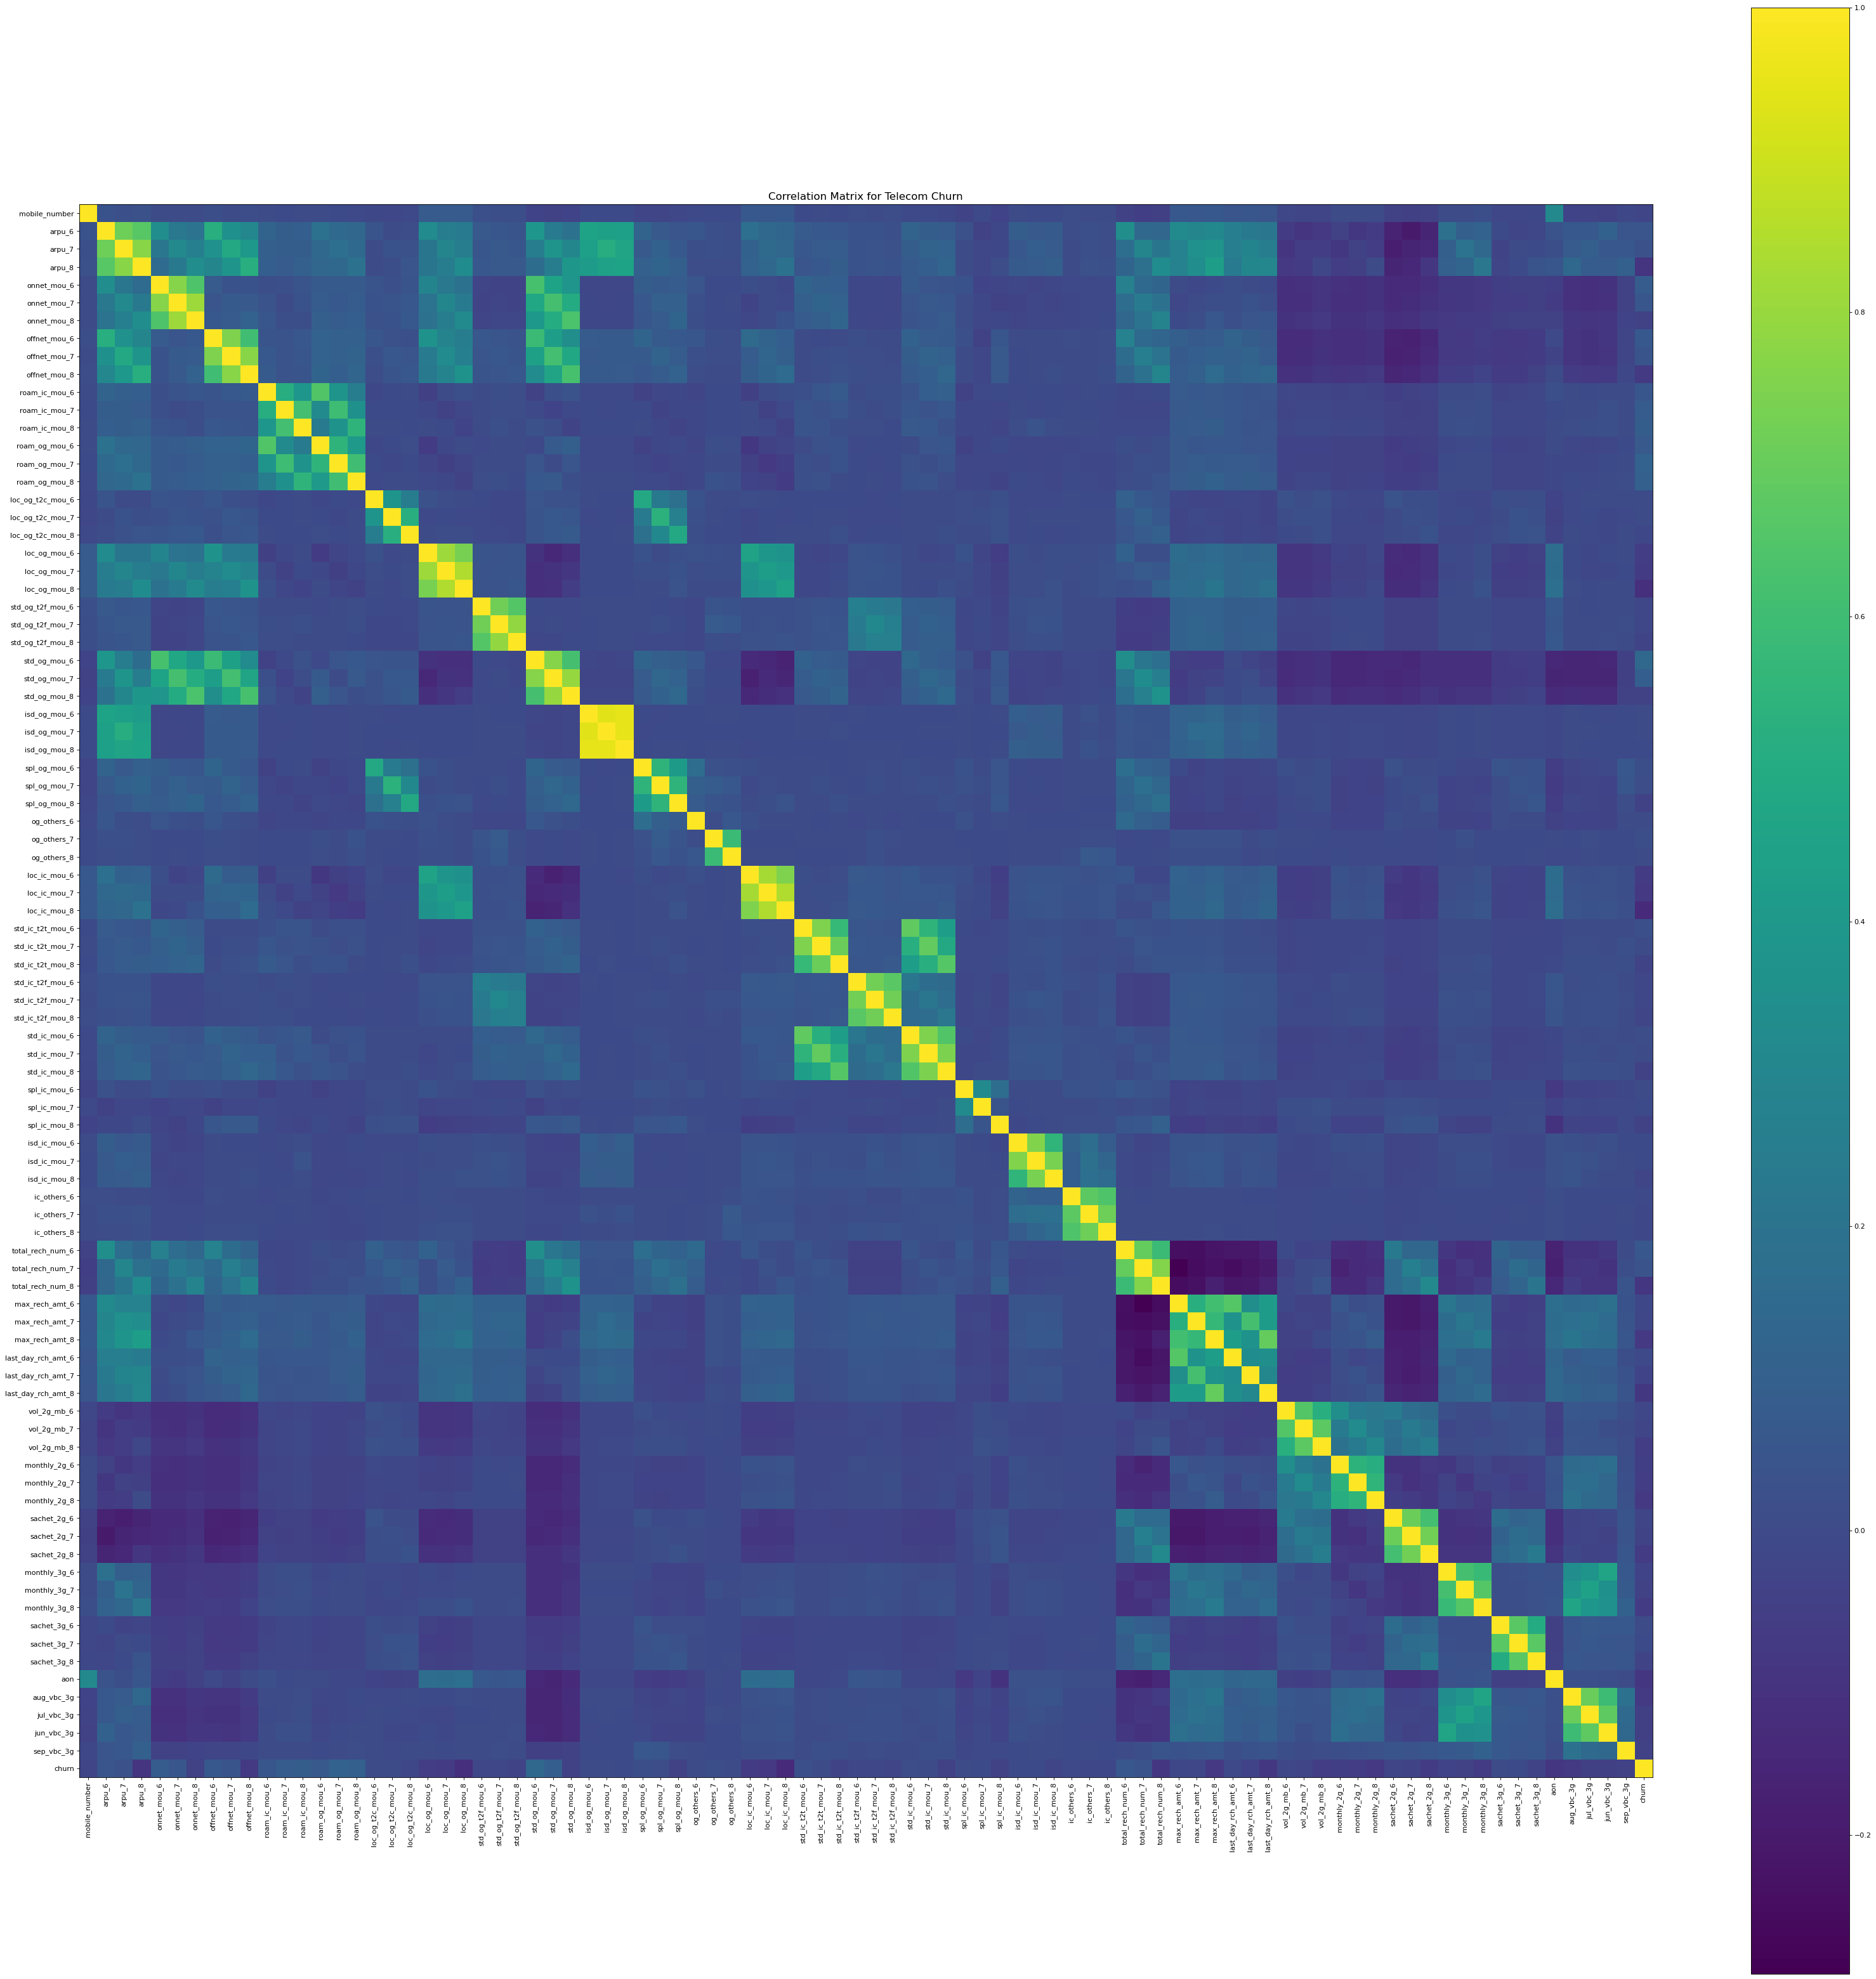

In [30]:
plotCorrelationMatrix(telecom_hv_cust, 50)

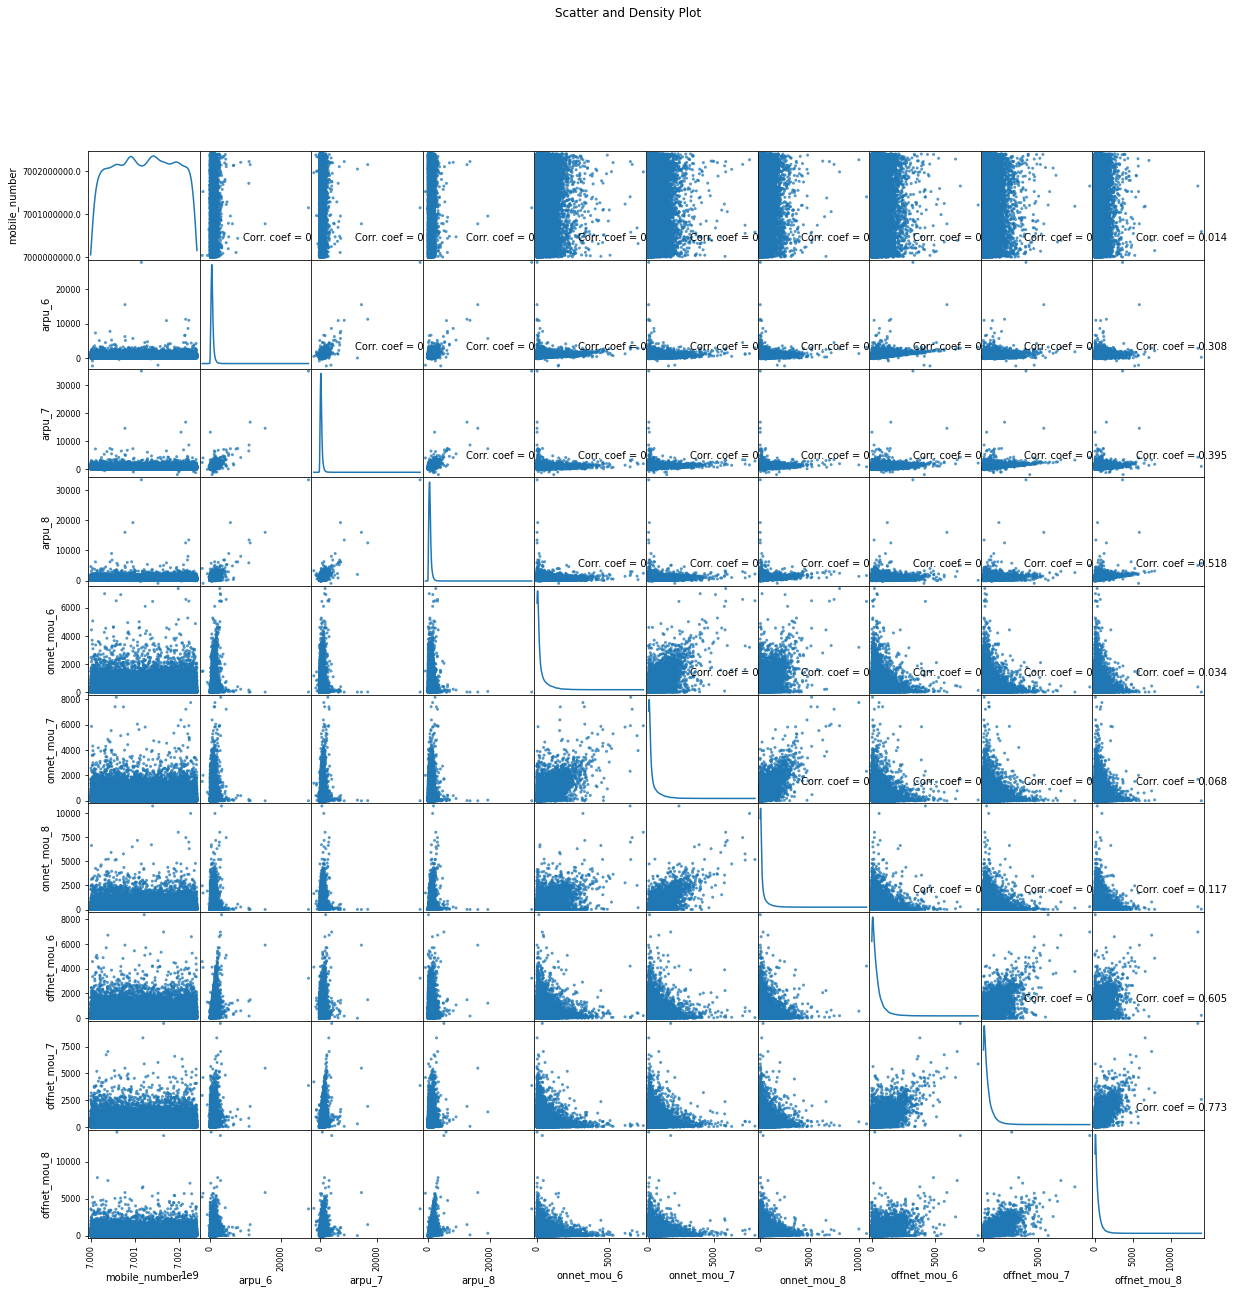

In [31]:
plotScatterMatrix(telecom_hv_cust, 20, 10)

### Deriving some new features from the existing columns

In [32]:
# creating a new column, which would be average of 6th & 7th months

# Filtering columns for 6th and 7th months
col_list = telecom_hv_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (telecom_hv_cust.shape)
# Calculating averages and create new columns
for idx, col in enumerate(col_list.unique()):
    avg_col_name = "avg_"+col+"_av67" # lets create the column name dynamically
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_hv_cust[avg_col_name] = (telecom_hv_cust[col_6]  + telecom_hv_cust[col_7])/ 2

(28504, 88)


In [33]:
# We dont need columns from which we have derived new features, we will drop those columns
print ("dimension of the updated dataset after creating dervied features:",telecom_hv_cust.shape)
col_to_drop = telecom_hv_cust.filter(regex='_6|_7').columns
telecom_hv_cust.drop(col_to_drop, axis=1, inplace=True)

print("dimension of the dataset after dropping un-necessary columns:",telecom_hv_cust.shape)

dimension of the updated dataset after creating dervied features: (28504, 115)
dimension of the dataset after dropping un-necessary columns: (28504, 61)


In [34]:
# Converting AON(given in days) to months
telecom_hv_cust['aon_mon'] = telecom_hv_cust['aon']/30
telecom_hv_cust.drop('aon', axis=1, inplace=True)
telecom_hv_cust['aon_mon'].head()

7     26.733333
8     10.500000
21    24.000000
23    20.133333
33    44.266667
Name: aon_mon, dtype: float64

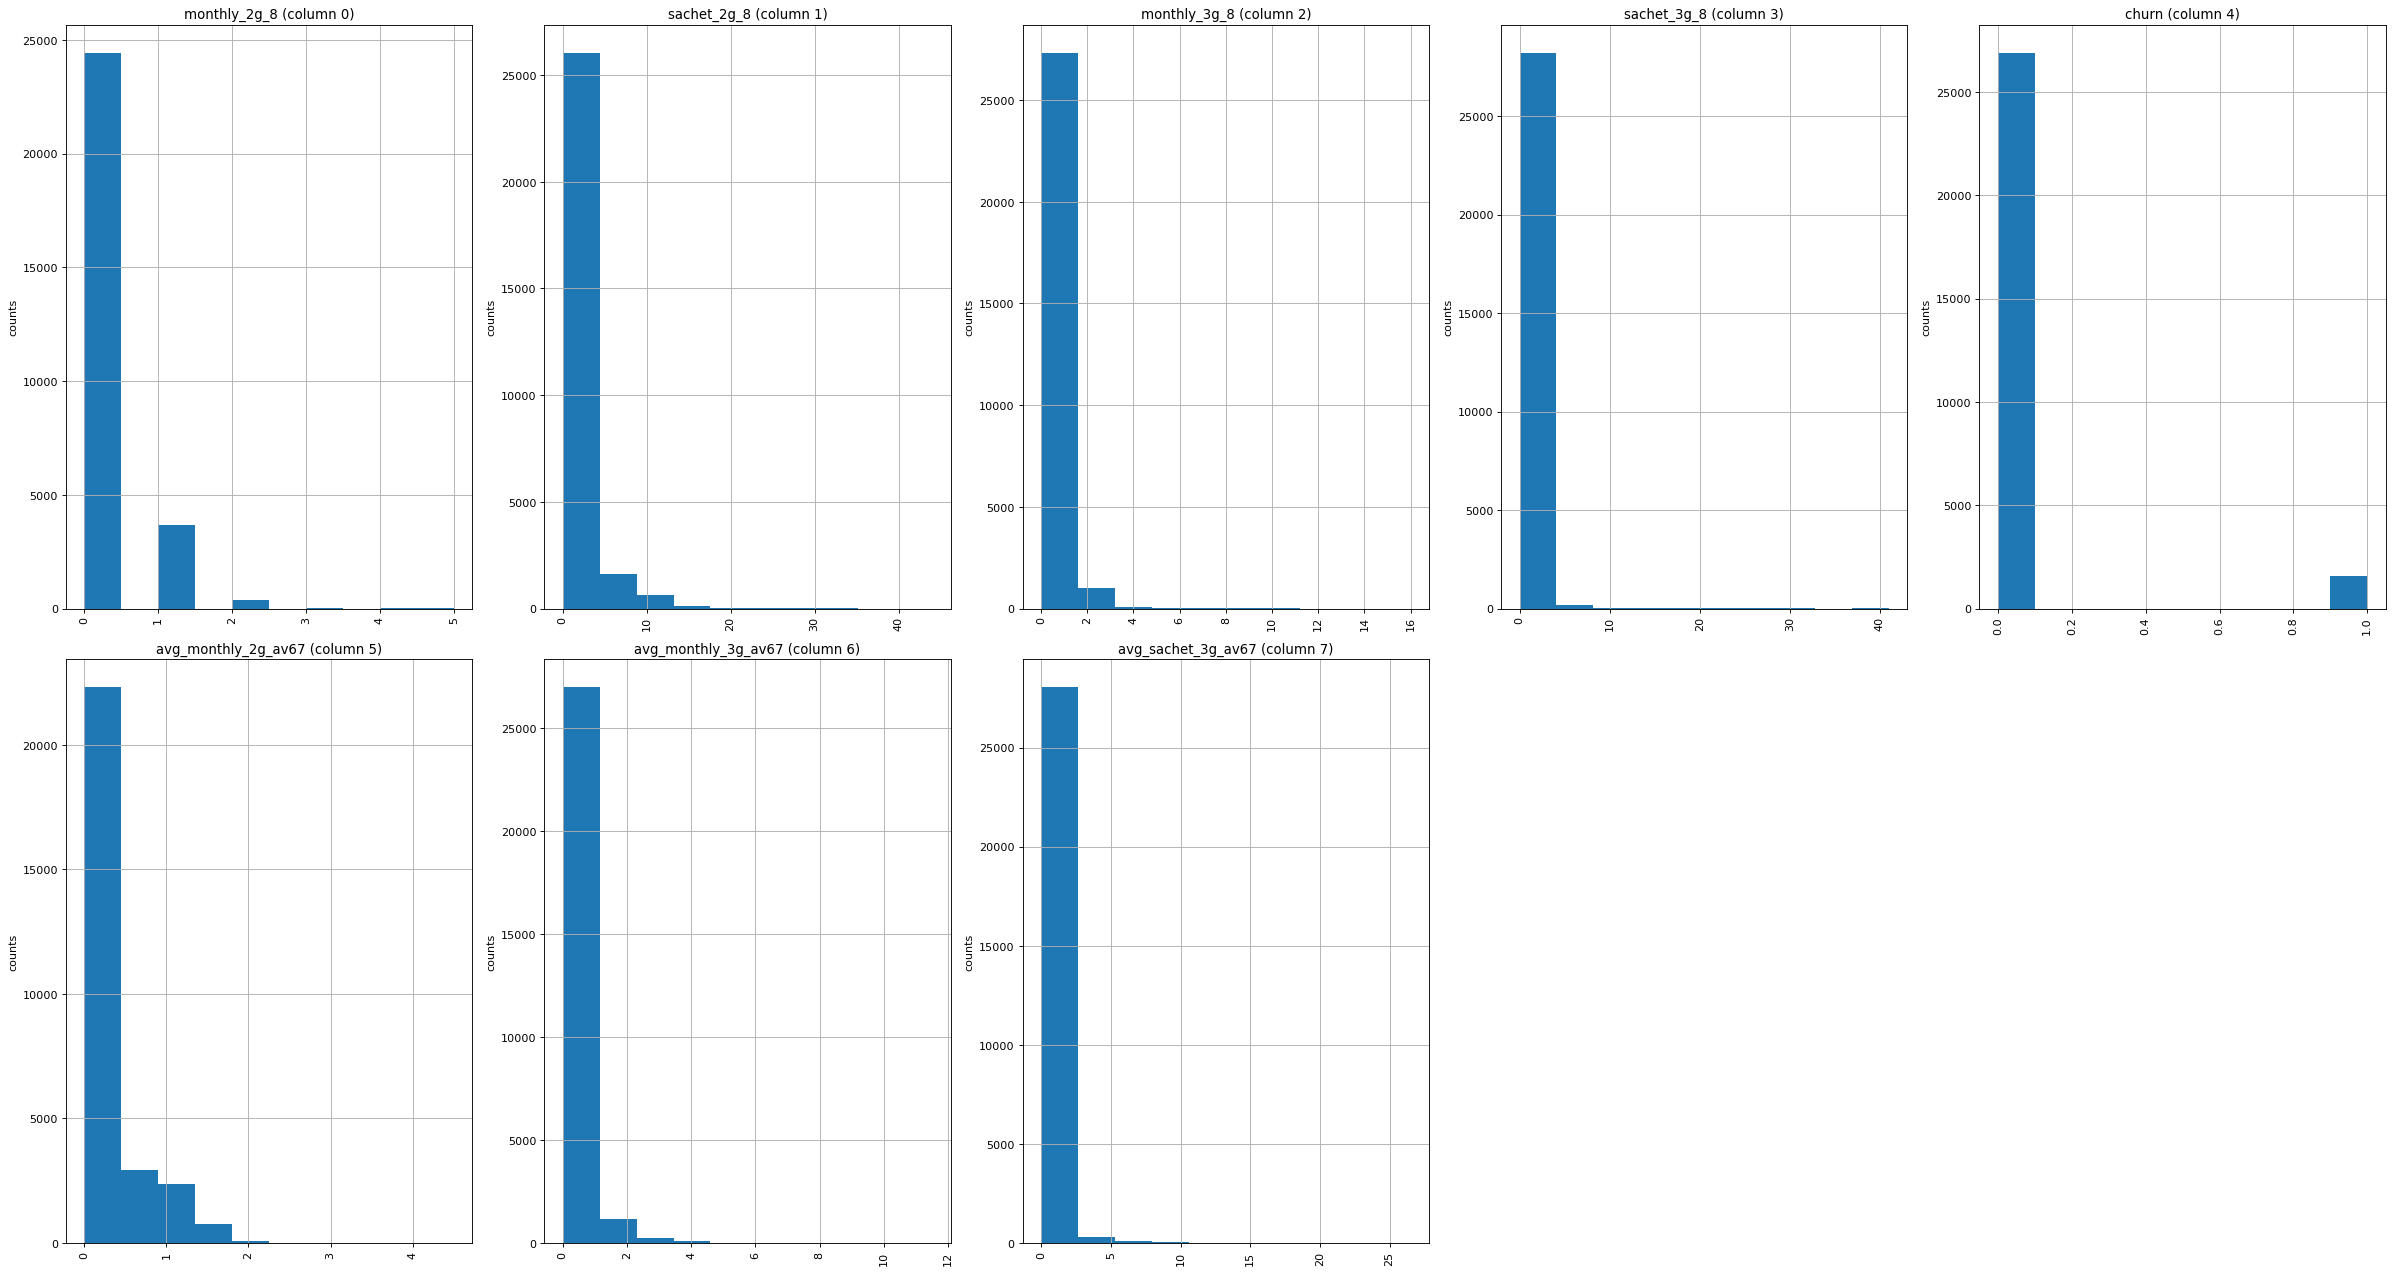

In [35]:
# plotting the plots with the updated dataset
plotPerColumnDistribution(telecom_hv_cust, 10, 5)

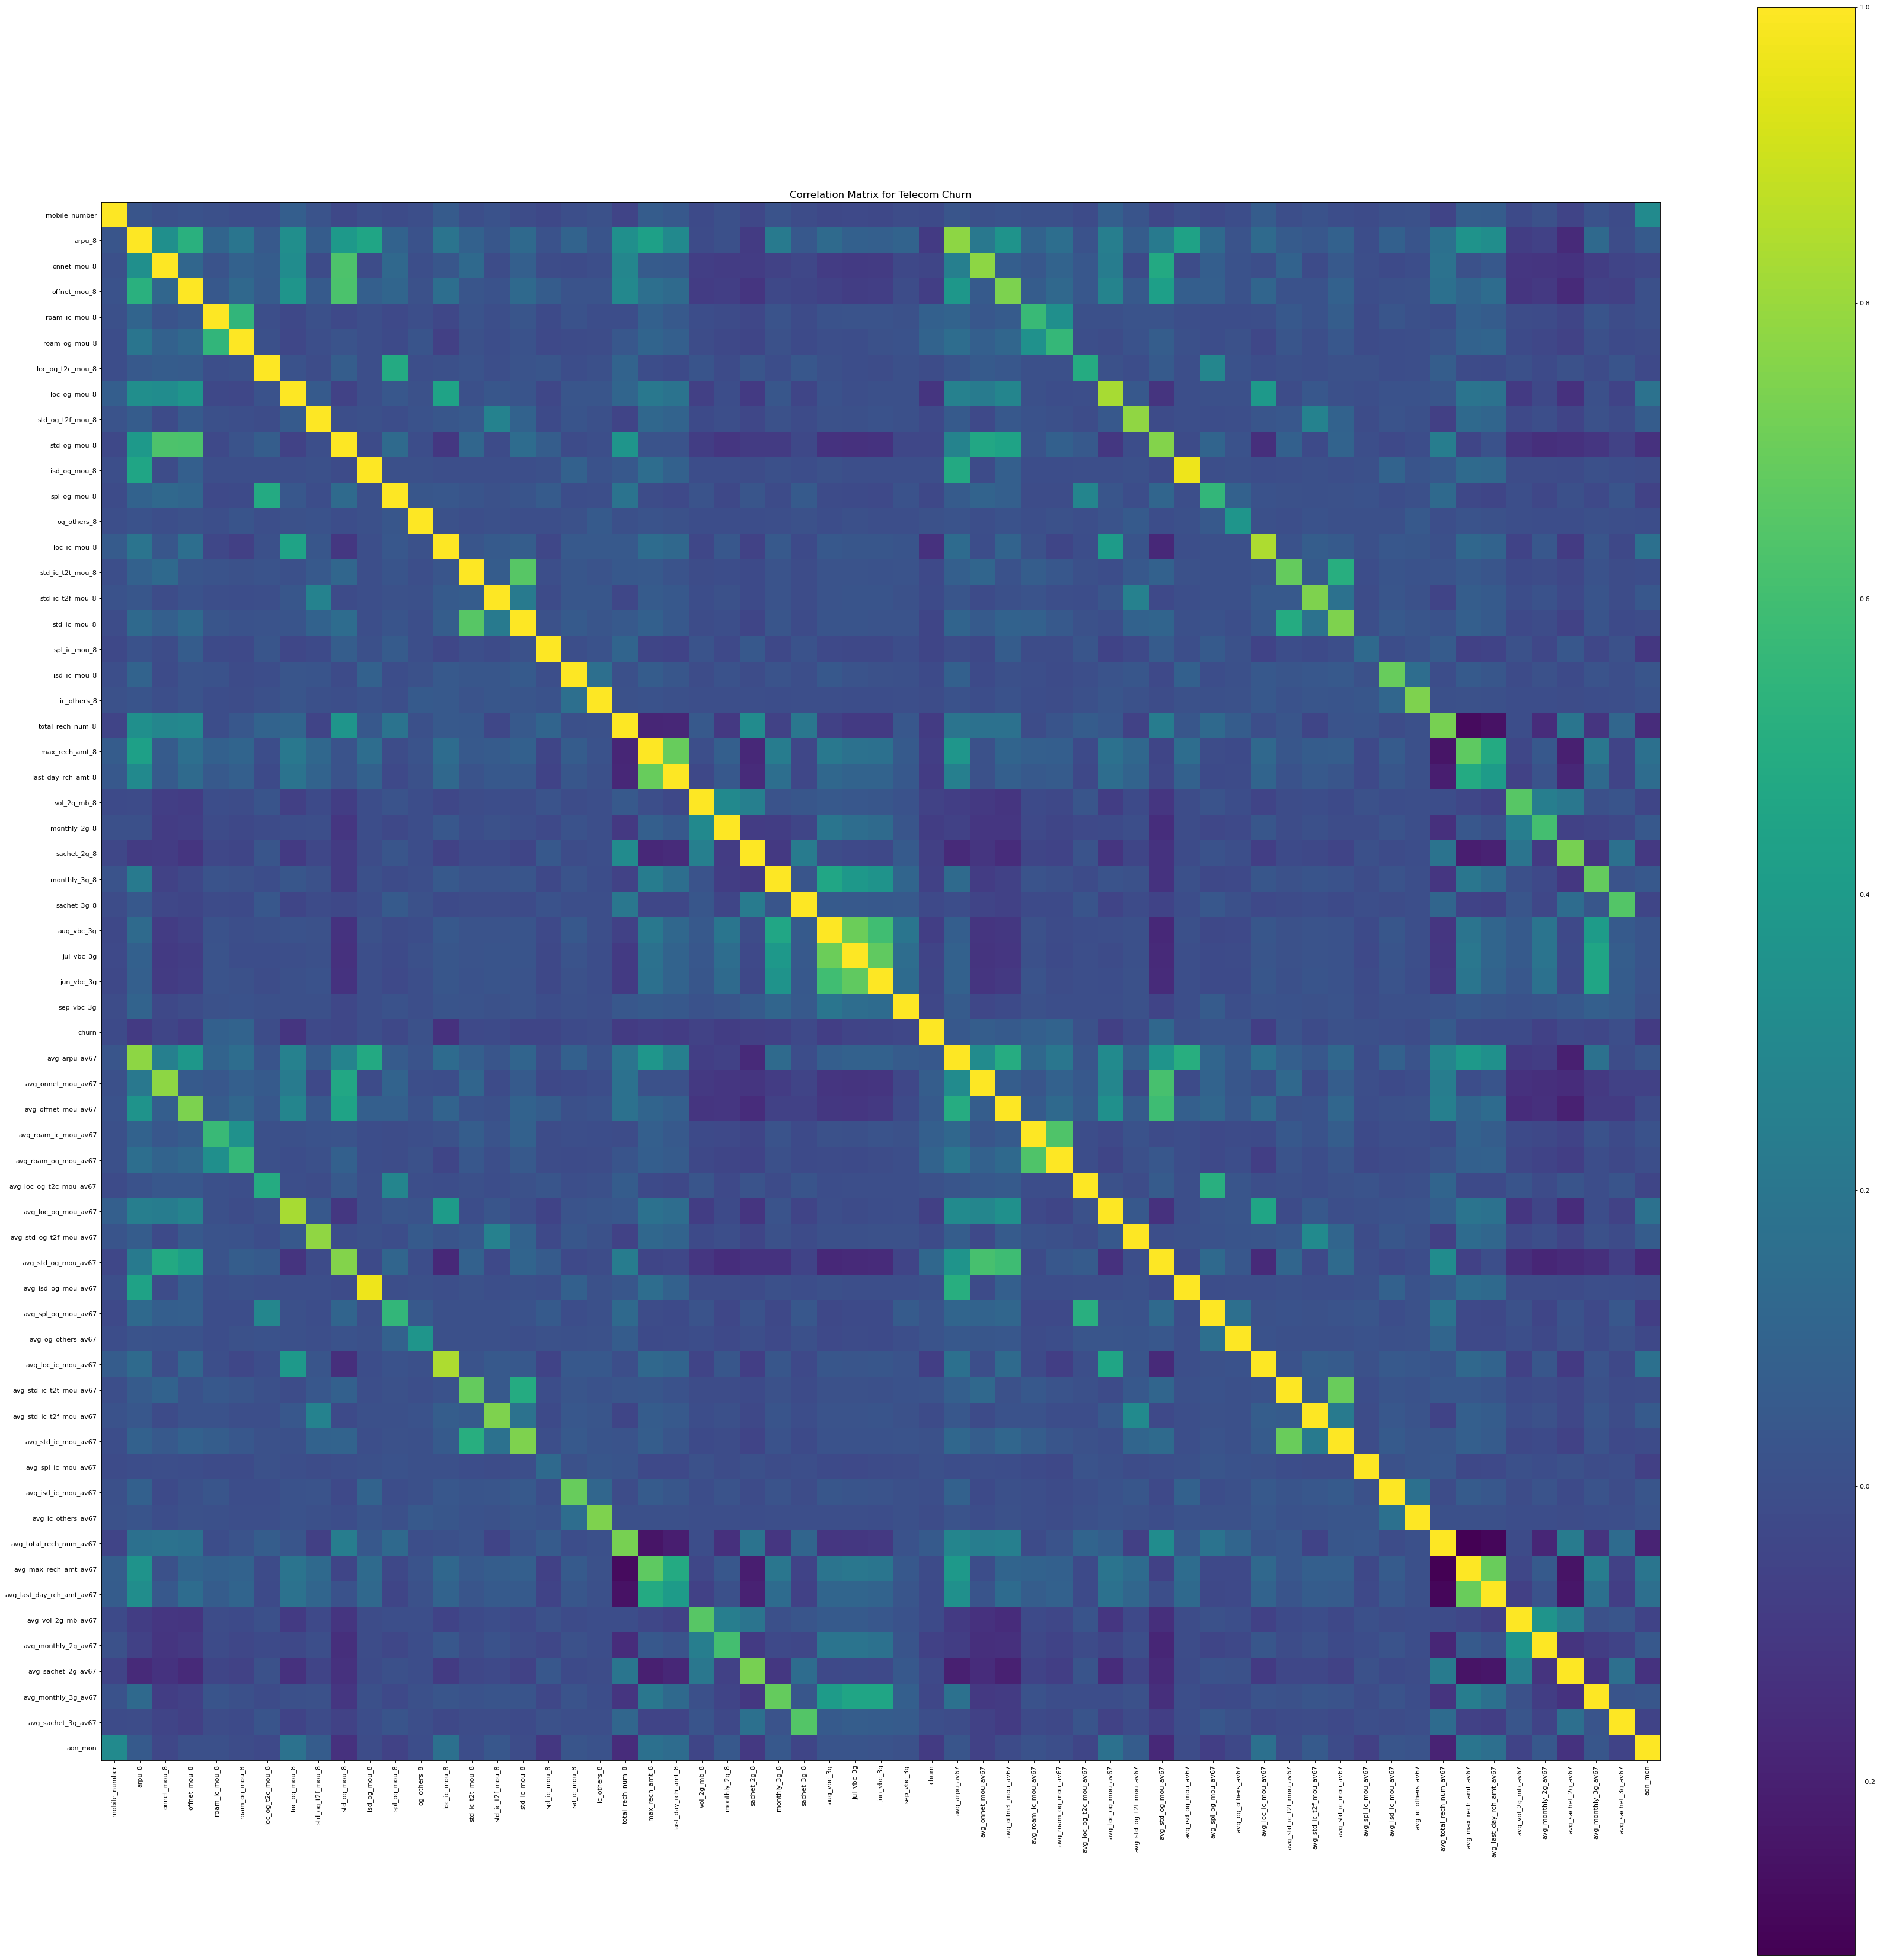

In [36]:
plotCorrelationMatrix(telecom_hv_cust, 53)

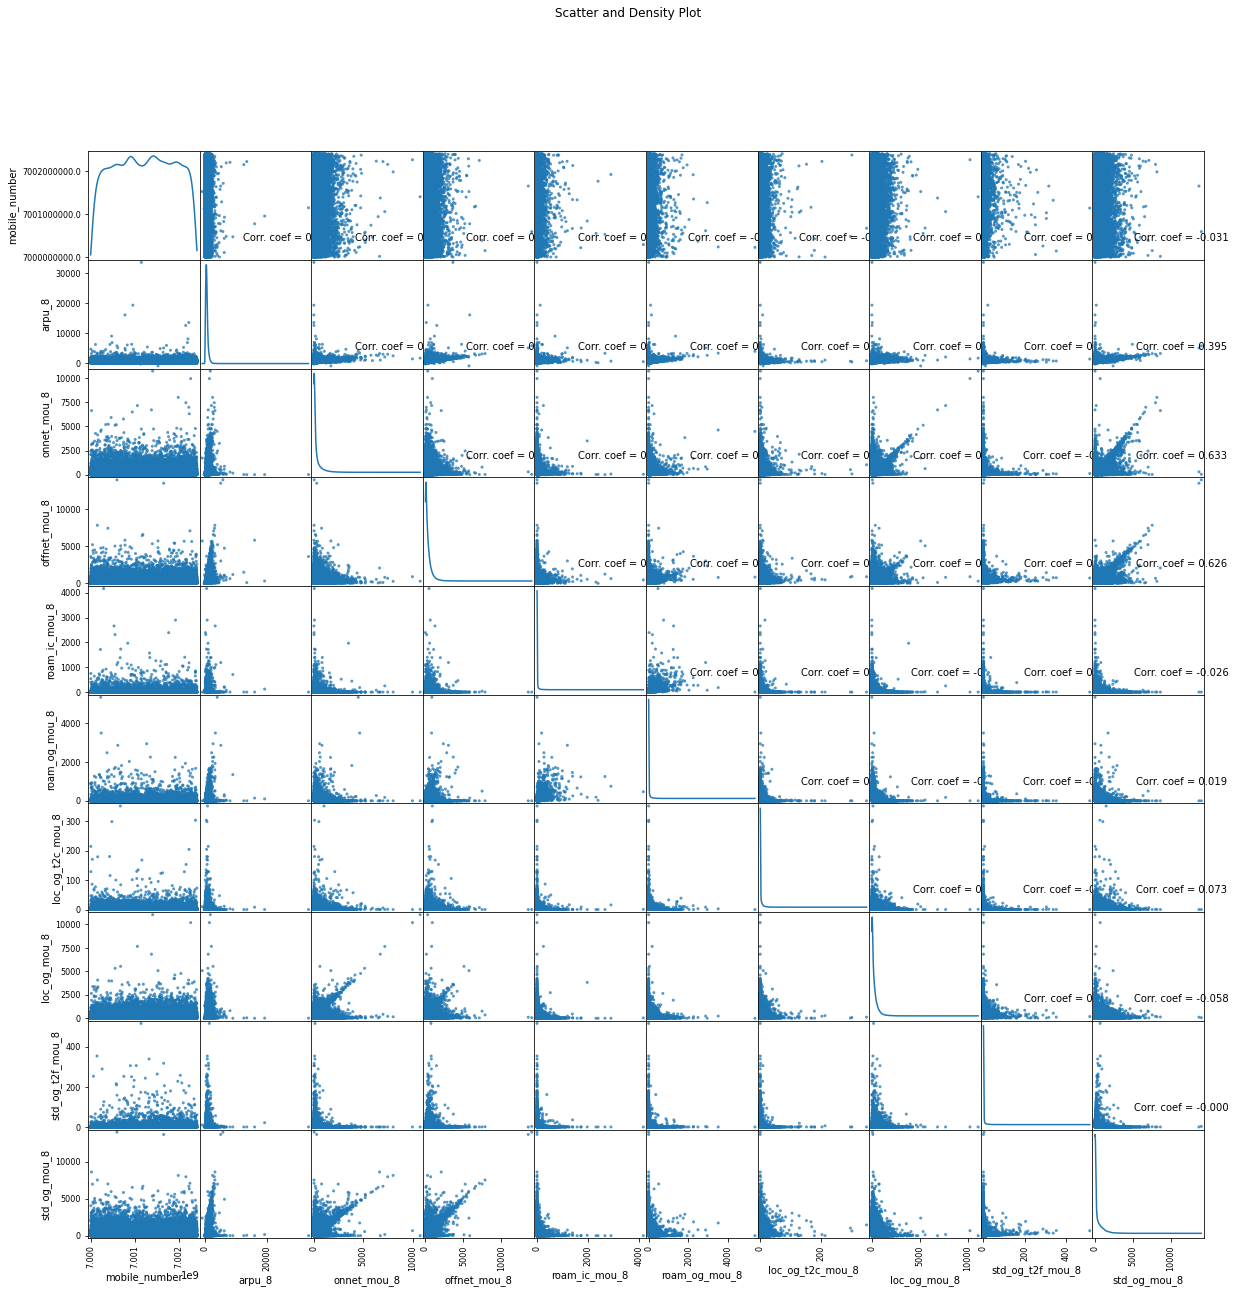

In [37]:
plotScatterMatrix(telecom_hv_cust, 20, 10)

Text(0.5, 1.0, 'Tenure Graph')

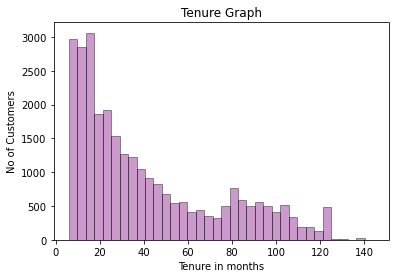

In [38]:
ax = sns.distplot(telecom_hv_cust['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'purple', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 10})
ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure in months')
ax.set_title('Tenure Graph')
# The graph below shows the tenure of the customers

In [39]:
# creating a new column tenure_range in DataFrame telecom_hv_cust based on the tenure (aon_mon) of customers
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_hv_cust['tenure_range'] = pd.cut(telecom_hv_cust['aon_mon'], tn_range, labels=tn_label)
telecom_hv_cust['tenure_range'].head()

7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
33        2-5 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

<AxesSubplot:>

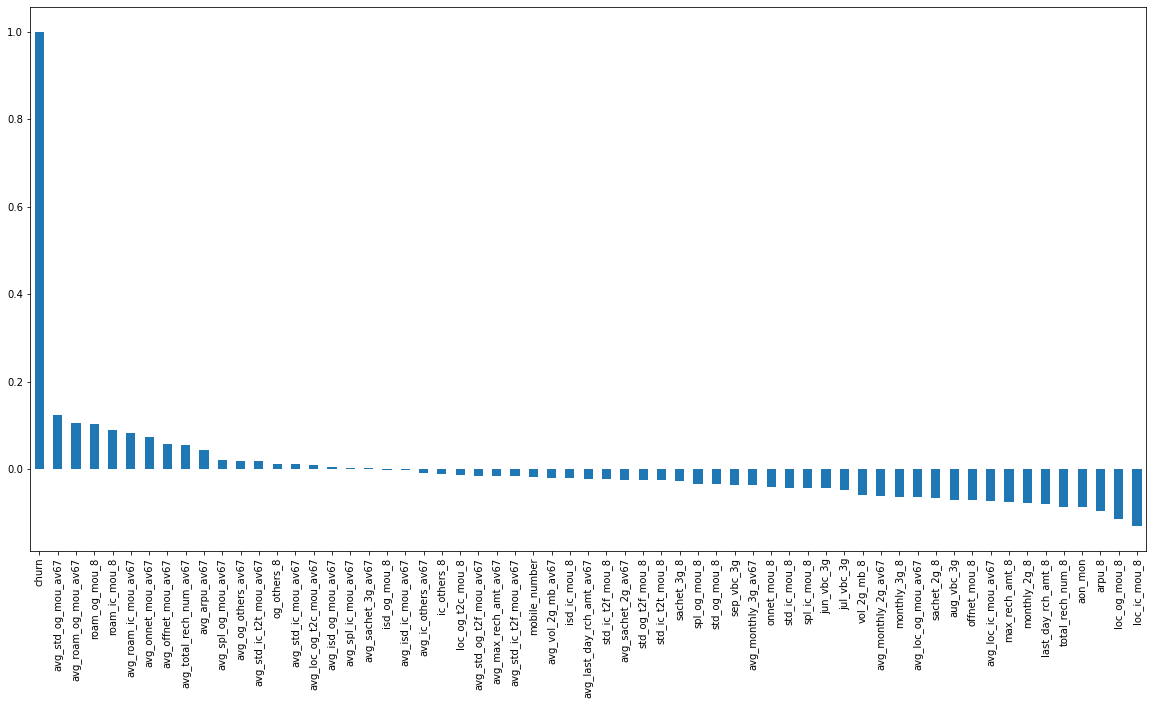

In [40]:
# lets check correlation of churn with other columns
plt.figure(figsize=(20,10))
telecom_hv_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

Observations : 
1. avg_std_og_mou_av67 (Avg std Outgoing Calls for 6th and 7th months) & avg_roam_og_mou_av67 (Avg roaming Outgoing calls for 6th and 7th months) are positively correlated with churn. 
2. loc_ic_mou_8 (Minutes of usage for incoming local calls for 8th month) & loc_og_mou_8 (Minutes of usage for outgoing local calls for 8th month) & arpu_8 (Average revenue per user for the 8th month) has negative correlation with churn.

<AxesSubplot:xlabel='total_rech_num_8', ylabel='arpu_8'>

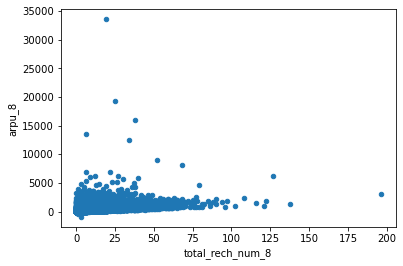

In [41]:
# Plotting a scatter plot between total recharge and avg revenue for the 8th month
telecom_hv_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',y='arpu_8')

<AxesSubplot:xlabel='aon_mon', ylabel='avg_arpu_av67'>

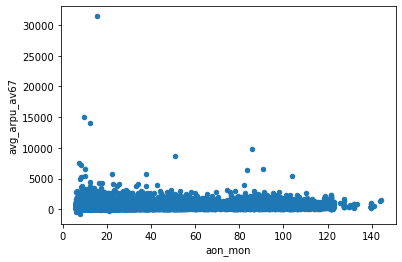

In [42]:
# plotting a scatter plot between tenure and revenue
telecom_hv_cust[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon',y='avg_arpu_av67')

<AxesSubplot:xlabel='churn', ylabel='aon_mon'>

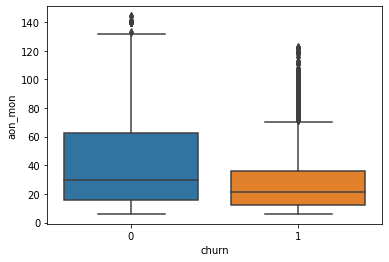

In [43]:
# Creating a box plot for the relationship between customer churn (churn) and tenure (aon_mon) in months
sns.boxplot(x = telecom_hv_cust.churn, y = telecom_hv_cust.aon_mon)

Observation: tenured customers tend not to churn much and continue to use telecom services comparing to non-tenured customers, it suggests a positive correlation between tenure and customer retention

Text(0.5, 1.0, 'Churn Vs Base Cost')

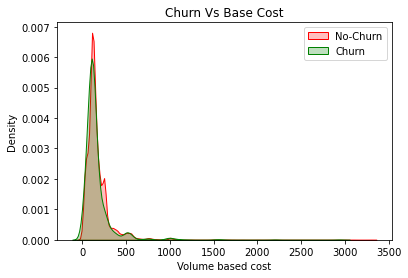

In [44]:
# churn Vs Base Cost
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Green", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Churn Vs Base Cost')

Observation:
- The green line shows that when churn occurs, most cost values cluster tightly around a relatively low value (around 300).

- The red line shows that without churn, cost values are more spread out over a wider range, centered around a higher value (around 1000-1500).

In simple terms, the presence of churn results in lower and more concentrated costs, while the absence of churn leads to higher and more dispersed costs across different values.

Text(0.5, 1.0, 'Distribution of Max Recharge Amount by churn')

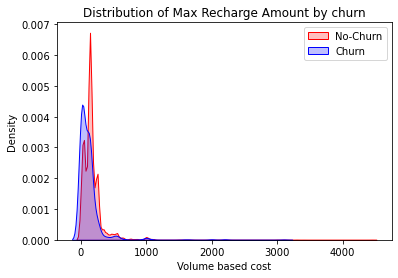

In [45]:
# churn vs max recharge amount
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

Observation:
- Churned customers have lower and more dispersed maximum recharge amounts/costs
- Non-churned customers have higher and more concentrated maximum recharge amounts/costs clustered around a specific value.

In [46]:
# creating a new dataset for model building
df = telecom_hv_cust[:].copy()

In [47]:
df.columns

Index(['mobile_number', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8',
       'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8',
       'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2f_mou_8',
       'std_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8',
       'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8',
       'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g',
       'churn', 'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2c_mou_av67', 'avg_loc_og_mou_av67',
       'avg_std_og_t2f_mou_av67', 'avg_std_og_mou_av67', 'avg_isd_og_mou_av67',
       'avg_spl_og_mou_av67', 'avg_og_others_av67', 'avg_loc_ic_mou_av67',
       'avg_std_ic_t2t_mou_av67', 'avg_std_ic_t2f_mou_av67',
       'avg_std

In [48]:
# dropping tenure range because it is highly correlated with aon_month column
df.drop('tenure_range', axis=1, inplace=True)
# Dropping mobile number
df.drop('mobile_number', axis=1, inplace=True)
df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,...,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,aon_mon
7,3171.480,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,...,15.465,5.0,1185.0,0.0,0.000,0.0,0.0,0.0,0.0,26.733333
8,137.362,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,...,0.000,20.0,122.0,25.0,178.000,0.5,0.5,0.0,0.0,10.500000
21,637.760,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,...,0.000,24.0,50.0,25.0,0.000,0.0,0.0,0.0,0.0,24.000000
23,366.966,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,...,2.675,4.0,89.5,89.5,0.240,0.0,0.0,1.0,0.0,20.133333
33,409.230,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,...,0.940,10.5,753.5,126.0,72.405,0.0,0.0,4.5,2.0,44.266667


## Model Building

In [49]:
# Splitting data set into X and y
X = df.drop(['churn'], axis=1)
y = df['churn']

df.drop('churn', axis=1, inplace=True)

In [50]:
#Performing scaling
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [51]:
# splitting into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,test_size=0.3,  random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (19952, 59)
Dimension of X_test: (8552, 59)


In [52]:
# As the dataset is imbalanced we habe to balance it 
from imblearn.over_sampling import SMOTE

# Initialize SMOTE 
sm = SMOTE()

# Generate synthetic samples to balance the dataset
X_tr, y_tr = sm.fit_resample(X_train, y_train)

In [53]:
print("Dimension of X_tr Shape:", X_tr.shape)
print("Dimension of y_tr Shape:", y_tr.shape)
print("Imbalance in Training dataset:",(y_tr != 0).sum()/(y_tr == 0).sum())

Dimension of X_tr Shape: (37666, 59)
Dimension of y_tr Shape: (37666,)
Imbalance in Training dataset: 1.0


In [54]:
#SVM
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Initialize Logistic Regression and Support Vector Machine models
lr = LogisticRegression()
svm = SVC(kernel='linear')

# Train the Support Vector Machine model
svm.fit(X_train, y_train)

# Predict using the SVM model
preds = svm.predict(X_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, preds)
print("Accuracy of linear SVM on test data:", accuracy)

Accuracy of linear SVM on test data: 0.9419400105244694


In [55]:
# Performing RFE for feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
lr = LogisticRegression()
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=15)  # Select the 15 most important features
rfe.fit(X_tr, y_tr)

RFE(estimator=LogisticRegression(), n_features_to_select=15)

In [56]:
# Performing RFE for feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
lr = LogisticRegression()
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=15)  # Select the 15 most important features
rfe.fit(X_tr, y_tr)

RFE(estimator=LogisticRegression(), n_features_to_select=15)

In [57]:
rfe_features = list(df.columns[rfe.support_])
print("15 most important features selected by RFE ", rfe_features)

15 most important features selected by RFE  ['onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'last_day_rch_amt_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sep_vbc_3g', 'avg_std_og_mou_av67', 'avg_loc_ic_mou_av67', 'aon_mon']


In [58]:
# Creating a new DataFrame with selected features from RFE
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]

# Assign the balanced target variable to y_rfe
y_rfe = y_tr

In [59]:
from sklearn.linear_model import LogisticRegression

# Initializing Logistic Regression model 
lr = LogisticRegression(random_state=1)

# Fitting the Logistic Regression model on the selected features and balanced target variable
lr.fit(X_rfe, y_rfe)

LogisticRegression(random_state=1)

In [60]:
# Creating a new DataFrame with selected features from RFE for the test set
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

# Predicting using the trained Logistic Regression model
y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
# Calculating and he confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_matrix)

# Calculate and print the accuracy on the test dataset
accuracy = lr.score(X_test_rfe, y_test)
print("Accuracy on the test dataset:", accuracy)

Confusion Matrix:
[[4200 1170]
 [  62  269]]
Accuracy on the test dataset: 0.7838975618312577


In [61]:
 #checking the classification report on the test dataset
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      5370
           1       0.19      0.81      0.30       331

    accuracy                           0.78      5701
   macro avg       0.59      0.80      0.59      5701
weighted avg       0.94      0.78      0.84      5701



- Precision: High for class 0 (non-churning customers) and low for class 1 (churning customers)
- Recall (Sensitivity): Good for both classes but slightly higher for class 1
- F1-Score: Higher for class 0, indicating better balance between precision and recall
- Support: More instances of class 0 compared to class 1
- Accuracy: Overall accuracy is 78%, indicating correct predictions for 78% of instances

In summary, the model performs well in identifying non-churning customers but needs improvement in predicting churning customers.

### Principal Component Analysis (PCA)

In [62]:
from imblearn.over_sampling import SVMSMOTE
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# Initializing an SVM estimator for SMOTE
svm_estimator = SVC()
# Defining the random state for reproducibility
r_state = 1

# Applying SMOTE to correct class imbalance
sm = SVMSMOTE(random_state=r_state, sampling_strategy =1,k_neighbors=9,)
X_tr, y_tr = sm.fit_resample(X_train, y_train)
print("Shape of balanced training set after SMOTE:", X_tr.shape)
print("Shape of balanced target variable after SMOTE:", y_tr.shape)

# Importing PCA and initialize with random_state
pca = PCA(random_state=100)

# Applying PCA on the balanced training data
X_tr_pca = pca.fit_transform(X_tr)
print("Shape of training set after PCA:", X_tr_pca.shape)

# Transforming the test data using the trained PCA model
X_test_pca = pca.transform(X_test)
print("Shape of testing set after PCA:", X_test_pca.shape)

Shape of balanced training set after SMOTE: (37666, 59)
Shape of balanced target variable after SMOTE: (37666,)
Shape of training set after PCA: (37666, 59)
Shape of testing set after PCA: (8552, 59)


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd

# Initializing Logistic Regression model with a high C value
lr_pca = LogisticRegression(C=1e9)

# Fitting the Logistic Regression model on the PCA-transformed training data
lr_pca.fit(X_tr_pca, y_tr)

# Making predictions using the trained model on the PCA-transformed test data
y_pred = lr_pca.predict(X_test_pca)

# Converting the prediction array into a DataFrame for easier manipulation (if needed)
y_pred_df = pd.DataFrame(y_pred)

# Evaluating the predictions using classification metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

# Printing the classification metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.8804957904583723
Precision: 0.2825219473264166
Recall: 0.7421383647798742
F1 Score: 0.4092485549132948


In [64]:
from sklearn.metrics import confusion_matrix

# Printing the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[7176  899]
 [ 123  354]]


In [65]:
# Getting the column names of the original DataFrame
col = list(df.columns)

# Creating a DataFrame to store PCA components and corresponding features
df_pca = pd.DataFrame({
    'PC-1': pca.components_[0],  # First principal component
    'PC-2': pca.components_[1],  # Second principal component
    'PC-3': pca.components_[2],  # Third principal component
    'Feature': col  # Corresponding feature name
})

# Displaying the first 10 rows of the DataFrame
print(df_pca.head(10))

       PC-1      PC-2      PC-3           Feature
0  0.132538  0.012567  0.333232            arpu_8
1  0.047695  0.118771  0.133429       onnet_mou_8
2  0.081704  0.110451  0.228884      offnet_mou_8
3  0.418177 -0.049923 -0.112454     roam_ic_mou_8
4  0.366071  0.007829 -0.080121     roam_og_mou_8
5  0.005914  0.021116  0.046743  loc_og_t2c_mou_8
6  0.013969 -0.036337  0.239860      loc_og_mou_8
7  0.010361 -0.028915  0.074541  std_og_t2f_mou_8
8  0.026716  0.194937  0.140892      std_og_mou_8
9  0.033281  0.015606  0.120888      isd_og_mou_8


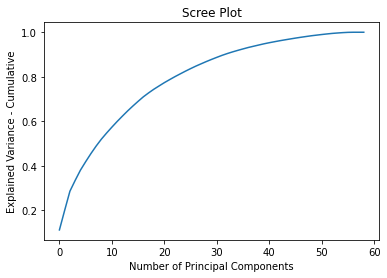

In [66]:
# Creating a scree plot to visualize explained variance by different principal components
fig = plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance - Cumulative')
plt.title('Scree Plot')
plt.show()

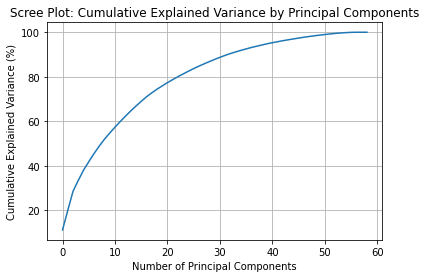

In [67]:
# Calculati the cumulative explained variance ratio
cumulative_var_ratio = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)

# Plotting the scree plot with the cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(cumulative_var_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Scree Plot: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

In [68]:
# PCA with 33 components
pca_33 = PCA(n_components=33)

# Fitting and transforming the training data
df_tr_pca_33 = pca_33.fit_transform(X_tr)
print("Shape of training data after PCA with 33 components:", df_tr_pca_33.shape)

# Transforming the testing data
df_test_pca_33 = pca_33.transform(X_test)
print("Shape of testing data after PCA with 33 components:", df_test_pca_33.shape)

Shape of training data after PCA with 33 components: (37666, 33)
Shape of testing data after PCA with 33 components: (8552, 33)


In [69]:
# Running the model using the selected variables
lr_pca1 = LogisticRegression(C=1e9)

# Fitting the Logistic Regression model on the PCA-transformed training data
lr_pca1.fit(df_tr_pca_33, y_tr)

# Making predictions using the trained model on the PCA-transformed test data
y_pred33 = lr_pca1.predict(df_test_pca_33)

# Converting the prediction array into a DataFrame for easier manipulation (if needed)
df_y_pred = pd.DataFrame(y_pred33)

# Calculating and print the accuracy score
from sklearn.metrics import accuracy_score
accuracy_with_pca = accuracy_score(y_test, y_pred33)
print("Accuracy with 33 PCAs:", accuracy_with_pca)

Accuracy with 33 PCAs: 0.8755846585594013


In [70]:
# Confusion matrix
print(confusion_matrix(y_test,y_pred33))

[[7145  930]
 [ 134  343]]


Conclusions from the model:
 - Model has 87% Accuracy 
 - 33 features can explain 90% variance in the dataset
 - Most important features: 
    - arpu_8,
    - onnet_mou_8
    - offnet_mou_8
    - roam_ic_mou_8
    - roam_og_mou_8
    

## Decision Tree

In [71]:
# lets create a decision tree now
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# Initializing an SVM estimator for SMOTE
svm_estimator = SVC()
# Defining the random state for reproducibility
r_state = 1

# Applying SMOTE to correct class imbalance
sm = SVMSMOTE(random_state=r_state, sampling_strategy =1,k_neighbors=9,)
X_tr, y_tr = sm.fit_resample(X_train, y_train)
print("Shape of X_tr after SMOTE:", X_tr.shape)
print("Shape of y_tr after SMOTE:", y_tr.shape)

Shape of X_tr after SMOTE: (37666, 59)
Shape of y_tr after SMOTE: (37666,)


In [72]:
# feature selection using lasso
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
svc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
svc_model = SelectFromModel(svc, prefit=True)
X_lasso = svc_model.transform(X_tr)
position = svc_model.get_support(indices=True)

print(X_lasso.shape)
print(position)

(37666, 31)
[ 0  1  4  6  8 10 12 15 16 19 21 22 23 24 25 26 27 30 31 32 34 35 39 43
 44 46 50 53 54 56 58]


In [73]:
# feature vector for decision tree
lasso_features = list(df.columns[position])
print("Lasso Features: ", lasso_features)

Lasso Features:  ['arpu_8', 'onnet_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aug_vbc_3g', 'sep_vbc_3g', 'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67', 'avg_std_og_mou_av67', 'avg_loc_ic_mou_av67', 'avg_std_ic_t2t_mou_av67', 'avg_std_ic_mou_av67', 'avg_total_rech_num_av67', 'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67', 'avg_monthly_3g_av67', 'aon_mon']


In [74]:
# importing decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# creating a decision tree with the default hyper parameter max depth to make the tree readable
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5)

In [75]:
# lets see the classification reort of the model built
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model predictions
X_test = pd.DataFrame(data=X_test).iloc[:, position]
y_pred1 = dt1.predict(X_test)

# classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8075
           1       0.30      0.69      0.41       477

    accuracy                           0.89      8552
   macro avg       0.64      0.80      0.68      8552
weighted avg       0.94      0.89      0.91      8552



In [76]:
# confusion matrix
print(confusion_matrix(y_test,y_pred1))
# accuracy of the decision tree
print('Decision Tree - Accuracy :',accuracy_score(y_test,y_pred1))

[[7298  777]
 [ 149  328]]
Decision Tree - Accuracy : 0.8917212347988774


## Hyperparameter fine tuning

In [77]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'max_depth': range(1, 40)}, return_train_score=True,
             scoring='accuracy')

In [78]:
# Grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.149171,0.004730,0.003368,0.006736,1,{'max_depth': 1},0.753783,0.751361,0.758662,0.803664,...,0.770988,0.020845,39,0.813155,0.813759,0.811967,0.798327,0.802376,0.807917,0.006335
1,0.275837,0.013413,0.000761,0.001094,2,{'max_depth': 2},0.794266,0.808177,0.815080,0.904421,...,0.848884,0.053447,38,0.847471,0.843195,0.841270,0.870839,0.863505,0.853256,0.011769
2,0.401462,0.008738,0.006770,0.008292,3,{'max_depth': 3},0.826520,0.848533,0.858357,0.902164,...,0.872672,0.036945,37,0.886068,0.876680,0.877941,0.871835,0.871005,0.876706,0.005393
3,0.548903,0.033204,0.000405,0.000809,4,{'max_depth': 4},0.831696,0.857427,0.873888,0.917695,...,0.883398,0.038499,36,0.899642,0.895132,0.891813,0.890253,0.886835,0.892735,0.004365
4,0.786936,0.025902,0.000635,0.001270,5,{'max_depth': 5},0.857977,0.880658,0.885039,0.923271,...,0.897760,0.030438,35,0.914344,0.904191,0.905253,0.901304,0.898517,0.904722,0.005354


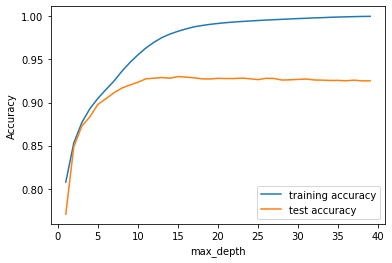

In [79]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

max_depth =10 seems to be the optimal one

In [80]:
# lets find optimal value of minimum sample leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [81]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.975246,0.123863,0.006258,0.007664,5,{'min_samples_leaf': 5},0.883196,0.912651,0.919421,0.944113,...,0.923194,0.025605,1,0.974778,0.970464,0.970000,0.969402,0.968573,0.970643,0.002162
1,1.791535,0.256744,0.004244,0.006088,25,{'min_samples_leaf': 25},0.871250,0.898712,0.906545,0.936413,...,0.912840,0.028293,2,0.944179,0.935486,0.935055,0.933063,0.932798,0.936116,0.004168
2,1.516430,0.061554,0.006749,0.008266,45,{'min_samples_leaf': 45},0.870056,0.894066,0.902031,0.933094,...,0.910743,0.029735,3,0.934057,0.924601,0.924037,0.921946,0.918362,0.924600,0.005210
3,1.402143,0.052766,0.009610,0.007859,65,{'min_samples_leaf': 65},0.863154,0.888225,0.893402,0.932431,...,0.905088,0.030945,4,0.927386,0.918661,0.916736,0.915076,0.912289,0.918030,0.005124
4,1.321411,0.085307,0.000000,0.000000,85,{'min_samples_leaf': 85},0.857048,0.886765,0.893933,0.928846,...,0.902831,0.031973,5,0.922607,0.914678,0.914380,0.912123,0.906846,0.914127,0.005085


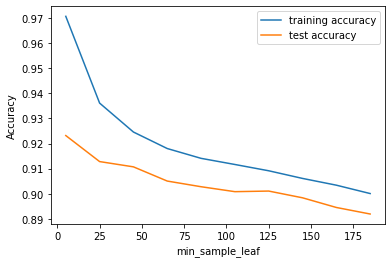

In [82]:
# plotting accuracies with min_sample_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_sample_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_sample_leaf = 25 seems to be the optimal one

In [83]:
# lets fine tune min sample split 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_split': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [84]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.363115,0.275196,0.000200,0.000400,5,{'min_samples_split': 5},0.884922,0.915040,0.924067,0.941723,...,0.923486,0.023179,1,0.995586,0.994425,0.993595,0.994392,0.994026,0.994405,0.000663
1,2.282158,0.073980,0.006862,0.007633,25,{'min_samples_split': 25},0.876958,0.909996,0.917695,0.943316,...,0.920540,0.027227,2,0.973384,0.967444,0.970929,0.967245,0.965486,0.968898,0.002854
2,2.205286,0.058319,0.003125,0.006249,45,{'min_samples_split': 45},0.872312,0.904952,0.915970,0.939997,...,0.917911,0.029033,3,0.962399,0.954867,0.959015,0.955199,0.952975,0.956891,0.003381
3,2.318405,0.271938,0.009718,0.007954,65,{'min_samples_split': 65},0.868065,0.900704,0.913315,0.938803,...,0.915469,0.030641,4,0.955629,0.947632,0.950984,0.946902,0.944579,0.949145,0.003836
4,2.189622,0.054143,0.006479,0.007944,85,{'min_samples_split': 85},0.863419,0.899907,0.909200,0.940661,...,0.913717,0.032262,5,0.948593,0.943550,0.945243,0.941094,0.938539,0.943404,0.003445


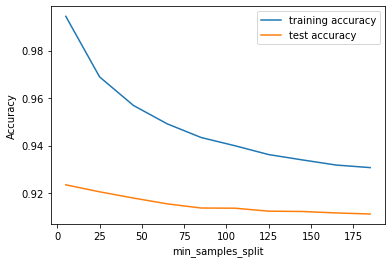

In [85]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_leaf=50 seems to be optimal

In [86]:
# Creating the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(25, 175, 50),
                         'min_samples_split': range(50, 150, 50)},
             verbose=1)

In [87]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)

Best Accuracy 0.9129198555820809


In [88]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=50)


In [89]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=25, min_samples_split=50,
                       random_state=100)

In [90]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

Accuracy Score for Decision Tree Final Model : 0.8914873713751169


Conclusion from the above Decision Tree model
1. 89% accuracy on the test dataset
2. lots of false positives in the confusion matrix

### Random Forest

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_lasso, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Random Forest Accuracy with Default Hyperparameter',metrics.accuracy_score(y_test, prediction_test))

Random Forest Accuracy with Default Hyperparameter 0.9423526660430309


In [92]:
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8075
           1       0.49      0.56      0.52       477

    accuracy                           0.94      8552
   macro avg       0.73      0.76      0.74      8552
weighted avg       0.95      0.94      0.94      8552



In [93]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[7794  281]
 [ 212  265]]


In [94]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specifying number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fitting tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 5)}, return_train_score=True,
             scoring='accuracy')

In [95]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.751689,0.272228,0.095362,0.014157,2,{'max_depth': 2},0.823865,0.839772,0.850392,0.899774,...,0.872034,0.044999,4,0.890947,0.885640,0.886503,0.867255,0.870806,0.880230,0.009387
1,9.765314,0.375445,0.136814,0.011020,7,{'max_depth': 7},0.876692,0.904022,0.914509,0.947564,...,0.920938,0.030568,3,0.940462,0.932367,0.933030,0.928085,0.924203,0.931629,0.005445
2,14.443742,0.294055,0.196361,0.006993,12,{'max_depth': 12},0.919166,0.946502,0.950617,0.967875,...,0.951230,0.018755,2,0.981548,0.977035,0.975575,0.974812,0.973551,0.976504,0.002763
3,17.158147,0.476507,0.237682,0.027022,17,{'max_depth': 17},0.927927,0.959113,0.964423,0.974778,...,0.960708,0.017687,1,0.992168,0.991604,0.991936,0.990774,0.989281,0.991153,0.001048


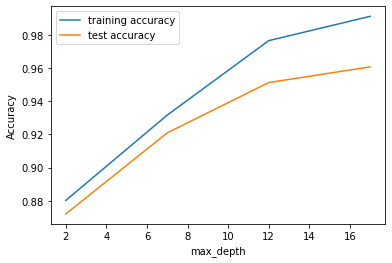

In [96]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [97]:
# Specify the number of folds for k-fold CV
n_folds = 5

# Parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# Instantiate the RandomForestClassifier model with a specified max_depth
rf = RandomForestClassifier(max_depth=4)

# Instantiate GridSearchCV with the RandomForestClassifier model, parameters, and cross-validation
rf = GridSearchCV(estimator=rf, param_grid=parameters, cv=n_folds, scoring="accuracy", return_train_score=True)

# Fit the GridSearchCV object on the Lasso-transformed training data and the balanced target variable
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=4),
             param_grid={'n_estimators': range(100, 1500, 400)},
             return_train_score=True, scoring='accuracy')

In [98]:
## scores of GridSearch CV
scores = rf.cv_results_

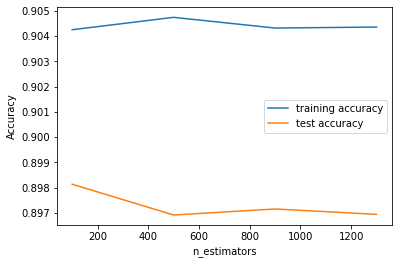

In [99]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [100]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': range(50, 400, 10)},
             return_train_score=True, scoring='accuracy')

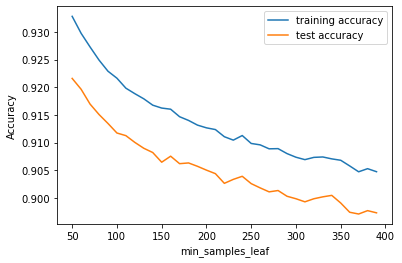

In [101]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 500, 25)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
rf.fit(X_lasso, y_tr)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [ ]:
# fit the grid search with the data
grid_search.fit(X_lasso, y_tr)
# optimal accuracy score and hyperparameters
print('Accuracy is',grid_search.best_score_,'using',grid_search.best_params_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

In [ ]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

In [ ]:
# accuracy score
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))

In [ ]:
# list of important features
X = df
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

## Conclusions from Random Forest

1. Local Incoming for Month 8, Average Revenue Per Customer for Month 8 and Max Recharge Amount for Month 8 are the most important predictor variables to predict churn.

## Overall Conclusions

1. Std Outgoing Calls and Revenue Per Customer are strong indicators of Churn.
2. Local Incoming and Outgoing Calls for 8th Month and avg revenue in 8th Month are the most important columns to predict churn.
3. cutomers with tenure less than 4 yrs are more likely to churn.
4. Max Recharge Amount is a strong feature to predict churn.
6. Random Forest produced the best prediction results followed by SVM.
